# AuNR DA figure 4

In [1]:
import sys
# add path for my packages
sys.path.append('./datasets')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

%precision 3
%matplotlib inline

# use my matplotlib style
plt.style.use('./datasets/my_rc_setting.mplstyle')

In [2]:
def calc_dif(idx, ito_data, glass_data):
    Eres_glass = glass_data['eres'][idx]
    AR_glass = glass_data['ratio'][idx]

    upper_min = ito_data[ito_data['ratio'] > AR_glass]['ratio'].min()
    lower_max = ito_data[ito_data['ratio'] < AR_glass]['ratio'].max()

    if abs(upper_min - AR_glass) > abs(lower_max - AR_glass):
        AR_ito_closest = lower_max
    else:
        AR_ito_closest = upper_min

    Eres_ito = ito_data[ito_data['ratio'] == AR_ito_closest]['eres']
    dEres_IG = Eres_ito - Eres_glass
    return dEres_IG


def calculate_mean(lst):
    return sum(lst) / len(lst)


def numerical_method(ito_data, glass_data, target_nsub):
    ito_nsub = 1.97
    glass_nsub = 1.52
    dnsub_IG = ito_nsub - glass_nsub
    dEres_IG_list = []
    for idx in range(glass_data.shape[0]):
        dEres_IG = calc_dif(idx, ito_data, glass_data)
        if dEres_IG.shape == (1,): 
            dEres_IG_list.append(dEres_IG.values)

    dEres_IG_mean = calculate_mean(dEres_IG_list)
    C = dEres_IG_mean / dnsub_IG
    target_Eres = C*(target_nsub - glass_nsub) + glass_data['eres']
    return target_Eres

## input data

In [3]:
glass_data = pd.read_csv('./datasets/090723_glass_training.csv')
glass_data = glass_data.drop(['R2'], axis=1)
original_data = pd.read_csv('./datasets/New_SPP.csv')
combined_data = pd.concat([glass_data, original_data], axis=0)
combined_data['volume'] = np.pi*(combined_data['width']**2)*combined_data['length']/4 - np.pi*(combined_data['width']**3)/12
combined_data['ratio'] = combined_data['length'] / combined_data['width']

combined_data = combined_data[(combined_data['width'] < 60) & (combined_data['length'] < 130)]
combined_data = combined_data.reset_index(drop=True)
print(combined_data.shape)

# all ITO data
ito_data = pd.read_csv('./datasets/111623_ito_training.csv')
ito_data['ratio'] = ito_data['length'] / ito_data['width']
ito_data = ito_data.drop(['corrcoef'], axis=1)

(1701, 7)


In [4]:
exp_data1 = pd.read_csv('./datasets/121324_Zhenyang_exp_al2o3_1.csv')
exp_data2 = pd.read_csv('./datasets/121324_Zhenyang_exp_al2o3_2.csv')
# convert str into list after reading csv
exp_data1['exp_ene'] = [ast.literal_eval(df) for df in exp_data1['exp_ene']]
exp_data1['exp_dfs'] = [ast.literal_eval(df) for df in exp_data1['exp_dfs']]
exp_data1['fitting'] = [ast.literal_eval(df) for df in exp_data1['fitting']]
exp_data2['exp_ene'] = [ast.literal_eval(df) for df in exp_data2['exp_ene']]
exp_data2['exp_dfs'] = [ast.literal_eval(df) for df in exp_data2['exp_dfs']]
exp_data2['fitting'] = [ast.literal_eval(df) for df in exp_data2['fitting']]
print(exp_data1.shape, exp_data2.shape)

exp_data1 = exp_data1.drop(8)
exp_data = pd.concat([exp_data1, exp_data2], axis=0, ignore_index=True)

print(exp_data.shape)

(44, 11) (21, 11)
(64, 11)


In [5]:
X_al2o3 = exp_data.drop(['exp_ene', 'exp_dfs', 'fitting', 'imax', 'width', 'length', 'aspect_ratio', 'volume', 'surface_area'], axis=1)
yw_al2o3 = exp_data['width']
yl_al2o3 = exp_data['length']
print(X_al2o3.shape)

(64, 2)


In [6]:
X_glass = combined_data.drop(['width', 'length', 'imax', 'ratio', 'volume'], axis=1)
yw_glass = combined_data['width']
yl_glass = combined_data['length']
print(X_glass.shape)

(1701, 2)


In [7]:
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 5, 10]
}

## glass to Al2O3

In [8]:
maew1_array = np.array([])
mael1_array = np.array([])
yw_exp1_df = pd.DataFrame()
yl_exp1_df = pd.DataFrame()
yw_pred1_df = pd.DataFrame()
yl_pred1_df = pd.DataFrame()

# Initialize GridSearchCV class
gsw = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# Initialize GridSearchCV class
gsl = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

gsw.fit(X_glass, yw_glass)
gsl.fit(X_glass, yl_glass)

wmodel1 = DecisionTreeRegressor(max_depth=gsw.best_params_['max_depth'],
                               min_samples_split=gsw.best_params_['min_samples_split'],
                               min_samples_leaf=gsw.best_params_['min_samples_leaf'])

lmodel1 = DecisionTreeRegressor(max_depth=gsl.best_params_['max_depth'],
                               min_samples_split=gsl.best_params_['min_samples_split'],
                               min_samples_leaf=gsl.best_params_['min_samples_leaf'])

# fitting
wmodel1.fit(X_glass, yw_glass)
lmodel1.fit(X_glass, yl_glass)

num_model = 15
for i in tqdm(range(num_model)):
    # create the specific number of data
    exp_data_sampled = exp_data.sample(30, random_state=i+12)
    exp_data_sampled = exp_data_sampled.reset_index(drop=True)

    X_exp_al2o3 = exp_data_sampled.drop(['exp_ene', 'exp_dfs', 'imax', 'width', 'length', 'fitting', 'aspect_ratio', 'volume', 'surface_area'], axis=1)
    yw_exp_al2o3 = exp_data_sampled['width']
    yl_exp_al2o3 = exp_data_sampled['length']

    # width predicting
    yw_pred1 = wmodel1.predict(X_exp_al2o3)
    yw_pred1_df = pd.concat([yw_pred1_df, pd.DataFrame(yw_pred1)], axis=1, sort=True)
    yw_exp1_df = pd.concat([yw_exp1_df, pd.DataFrame(yw_exp_al2o3)], axis=1, sort=True)
    maew1 = mean_absolute_error(yw_exp_al2o3, yw_pred1)
    maew1_array = np.append(maew1_array, maew1)

    # length predicting
    yl_pred1 = lmodel1.predict(X_exp_al2o3)
    yl_pred1_df = pd.concat([yl_pred1_df, pd.DataFrame(yl_pred1)], axis=1, sort=True)
    yl_exp1_df = pd.concat([yl_exp1_df, pd.DataFrame(yl_exp_al2o3)], axis=1, sort=True)
    mael1 = mean_absolute_error(yl_exp_al2o3, yl_pred1)
    mael1_array = np.append(mael1_array, mael1)
    
yw_pred1_df.columns = ['model'+str(i+1) for i in range(num_model)]
yl_pred1_df.columns = ['model'+str(i+1) for i in range(num_model)]
yw_exp1_df.columns = ['model'+str(i+1) for i in range(num_model)]
yl_exp1_df.columns = ['model'+str(i+1) for i in range(num_model)]

100%|██████████| 15/15 [00:00<00:00, 250.01it/s]


## Corr. Glass to Al2O3

In [9]:
Al2O3_nsub = 1.76
Al2O3_Eres = numerical_method(ito_data, combined_data, target_nsub=Al2O3_nsub)
X_glass['eres'] = Al2O3_Eres

In [10]:
maew2_array = np.array([])
mael2_array = np.array([])
yw_exp2_df = pd.DataFrame()
yl_exp2_df = pd.DataFrame()
yw_pred2_df = pd.DataFrame()
yl_pred2_df = pd.DataFrame()

# Initialize GridSearchCV class
gsw = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# Initialize GridSearchCV class
gsl = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

gsw.fit(X_glass, yw_glass)
gsl.fit(X_glass, yl_glass)

wmodel2 = DecisionTreeRegressor(max_depth=gsw.best_params_['max_depth'],
                               min_samples_split=gsw.best_params_['min_samples_split'],
                               min_samples_leaf=gsw.best_params_['min_samples_leaf'])

lmodel2 = DecisionTreeRegressor(max_depth=gsl.best_params_['max_depth'],
                               min_samples_split=gsl.best_params_['min_samples_split'],
                               min_samples_leaf=gsl.best_params_['min_samples_leaf'])

# fitting
wmodel2.fit(X_glass, yw_glass)
lmodel2.fit(X_glass, yl_glass)

for i in tqdm(range(num_model)):
    # create the specific number of data
    exp_data_sampled = exp_data.sample(30, random_state=i+12)
    exp_data_sampled = exp_data_sampled.reset_index(drop=True)

    X_exp_al2o3 = exp_data_sampled.drop(['exp_ene', 'exp_dfs', 'imax', 'width', 'length', 'fitting', 'aspect_ratio', 'volume', 'surface_area'], axis=1)
    yw_exp_al2o3 = exp_data_sampled['width']
    yl_exp_al2o3 = exp_data_sampled['length']

    yw_pred2 = wmodel2.predict(X_exp_al2o3)
    yw_pred2_df = pd.concat([yw_pred2_df, pd.DataFrame(yw_pred2)], axis=1, sort=True)
    yw_exp2_df = pd.concat([yw_exp2_df, pd.DataFrame(yw_exp_al2o3)], axis=1, sort=True)
    maew2 = mean_absolute_error(yw_exp_al2o3, yw_pred2)
    maew2_array = np.append(maew2_array, maew2)

    yl_pred2 = lmodel2.predict(X_exp_al2o3)
    yl_pred2_df = pd.concat([yl_pred2_df, pd.DataFrame(yl_pred2)], axis=1, sort=True)
    yl_exp2_df = pd.concat([yl_exp2_df, pd.DataFrame(yl_exp_al2o3)], axis=1, sort=True)
    mael2 = mean_absolute_error(yl_exp_al2o3, yl_pred2)
    mael2_array = np.append(mael2_array, mael2)
    
yw_pred2_df.columns = ['model'+str(i+1) for i in range(num_model)]
yl_pred2_df.columns = ['model'+str(i+1) for i in range(num_model)]
yw_exp2_df.columns = ['model'+str(i+1) for i in range(num_model)]
yl_exp2_df.columns = ['model'+str(i+1) for i in range(num_model)]

100%|██████████| 15/15 [00:00<00:00, 230.71it/s]


In [11]:
model_to_vis = mael1_array.argmin()
yw_pred1 = yw_pred1_df['model' + str(model_to_vis+1)]
yl_pred1 = yl_pred1_df['model' + str(model_to_vis+1)]
yw_exp1 = yw_exp1_df['model' + str(model_to_vis+1)]
yl_exp1 = yl_exp1_df['model' + str(model_to_vis+1)]

yw_pred2 = yw_pred2_df['model' + str(model_to_vis+1)]
yl_pred2 = yl_pred2_df['model' + str(model_to_vis+1)]
yw_exp2 = yw_exp2_df['model' + str(model_to_vis+1)]
yl_exp2 = yl_exp2_df['model' + str(model_to_vis+1)]

## final plot

C:\Users\katsuya2\AppData\Local\Temp\ipykernel_16896\1570468770.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


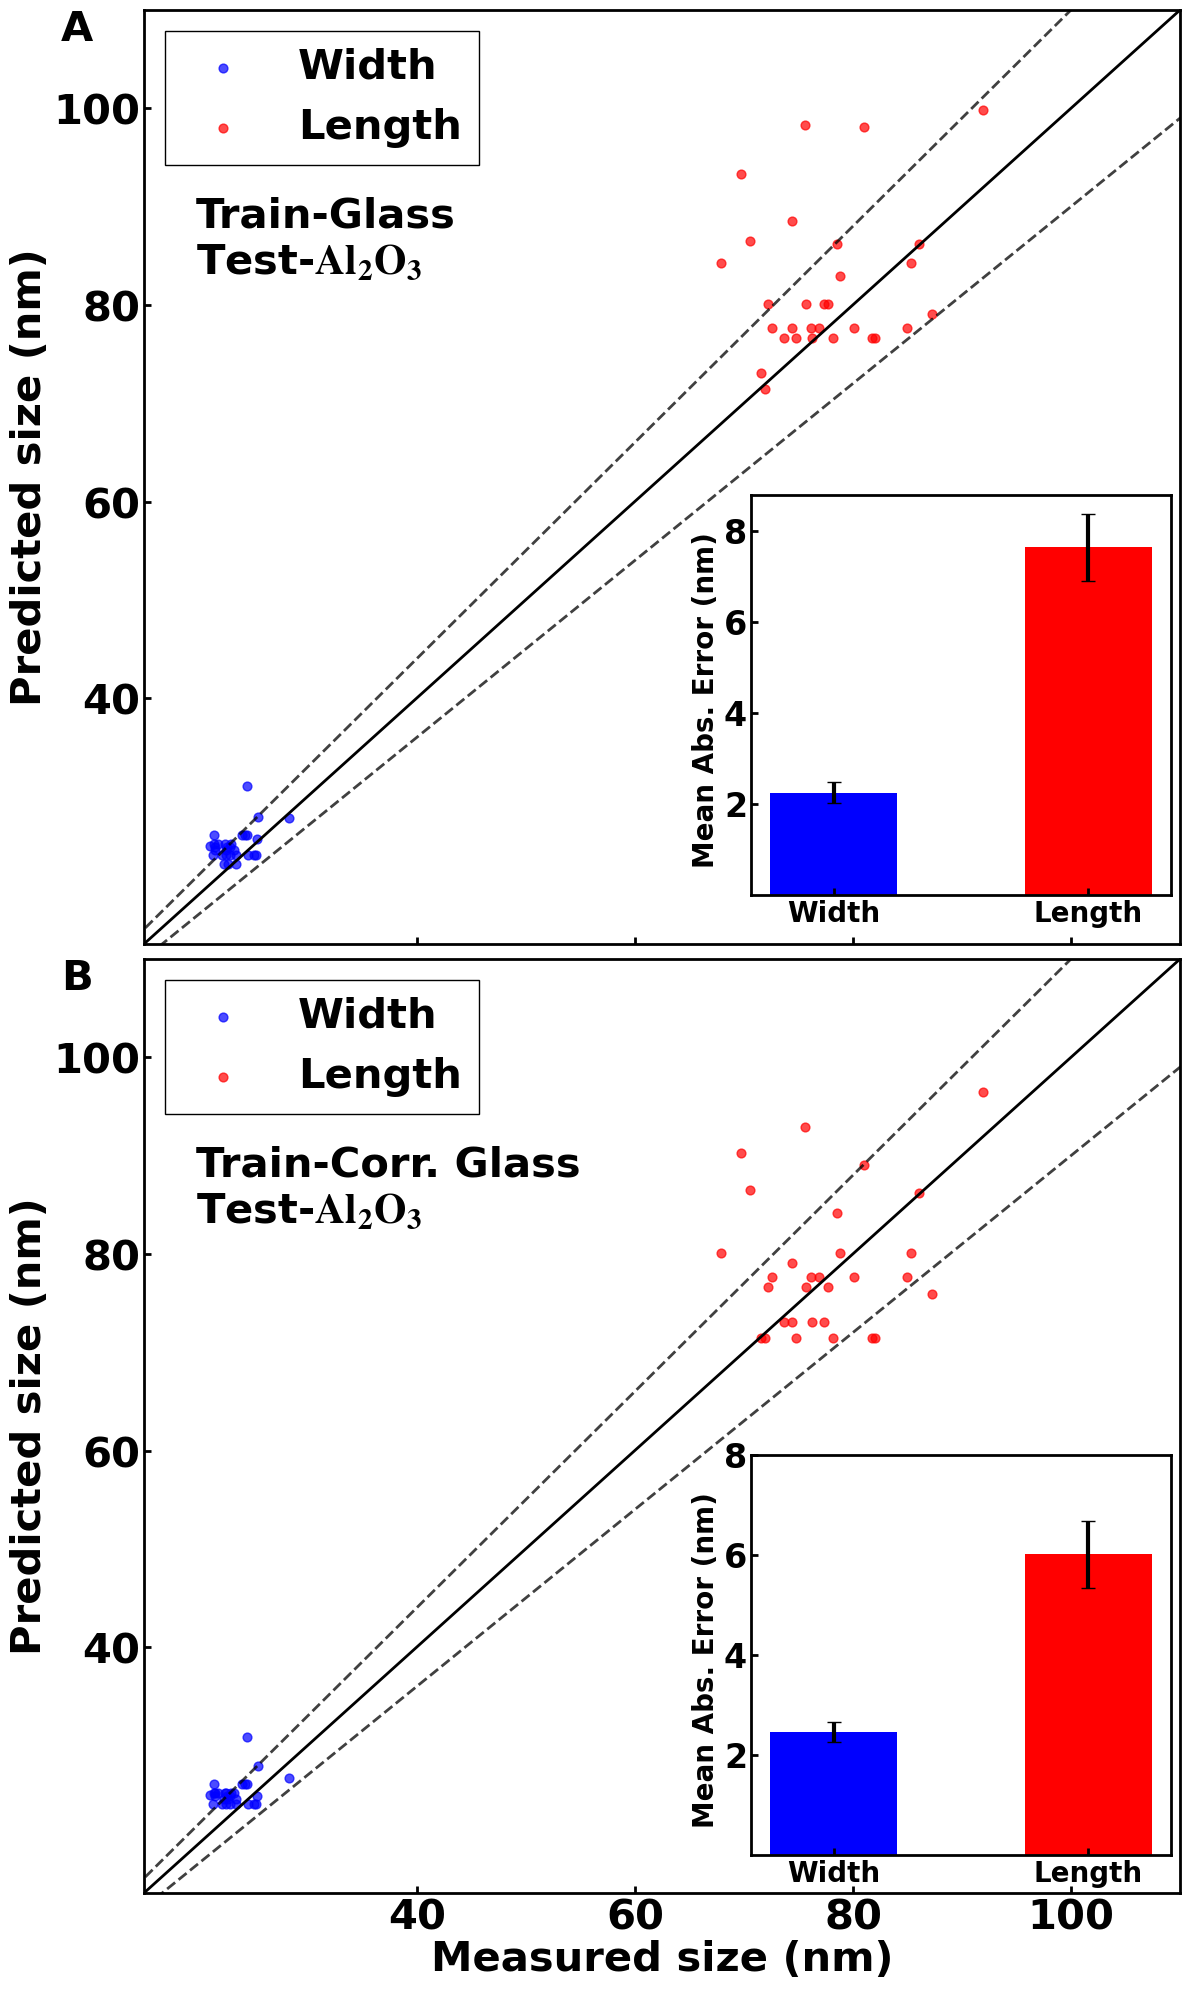

In [12]:
fig = plt.figure(figsize=(12, 20))  # Adjust size for vertical alignment
grid = fig.add_gridspec(2, 1, height_ratios=[1, 1])  # Single column layout

# First subplot (A)
axA = fig.add_subplot(grid[0, 0])
axA.scatter(yw_exp1, yw_pred1, s=40, c='b', alpha=.7, label=f'Width')
axA.scatter(yl_exp1, yl_pred1, s=40, c='r', alpha=.7, label=f'Length')

x = np.arange(-1, 181)
axA.plot(x, x, c='k', lw=2)
axA.plot(x, 1.1*x, c='k', linestyle='--', lw=2, alpha=0.75)
axA.plot(x, 0.9*x, c='k', linestyle='--', lw=2, alpha=0.75)

axA.set_xticks([40, 60, 80, 100])
axA.set_xticklabels([])
axA.set_yticks([40, 60, 80, 100])
axA.tick_params(axis='both', labelsize=30, pad=3)
axA.set_ylabel('Predicted size (nm)', fontsize=30)
axA.set_xlim(15, 110)
axA.set_ylim(15, 110)
axA.legend(loc='upper left', fontsize=30)
axA.text(-0.08, 1, 'A', ha='left', va='top', transform=axA.transAxes, fontsize=30)
axA.text(0.05, 0.8, 'Train-Glass\nTest-$\\mathrm{{Al_2O_3}}$', ha='left', va='top', transform=axA.transAxes, fontsize=30)

# Manual inset for A
inset_A = fig.add_axes([0.63, 0.55, 0.35, 0.2])  # Adjust position and size (x, y, width, height)
index = [0, 1]
inset_A.bar(index, [maew1_array.mean(), mael1_array.mean()], yerr=[maew1_array.std(), mael1_array.std()], capsize=5, width=0.5, color=['b', 'r'])
inset_A.set_xticks(index)
inset_A.set_xticklabels(['Width', 'Length'], fontsize=20)
inset_A.set_ylabel('Mean Abs. Error (nm) ', fontsize=20)
inset_A.set_yticks([2, 4, 6, 8])

# Second subplot (B)
axB = fig.add_subplot(grid[1, 0])
axB.scatter(yw_exp2, yw_pred2, s=40, c='b', alpha=.7, label=f'Width')
axB.scatter(yl_exp2, yl_pred2, s=40, c='r', alpha=.7, label=f'Length')
axB.plot(x, x, c='k', lw=2)
axB.plot(x, 1.1*x, c='k', linestyle='--', lw=2, alpha=0.75)
axB.plot(x, 0.9*x, c='k', linestyle='--', lw=2, alpha=0.75)

axB.set_xticks([40, 60, 80, 100])
axB.set_yticks([40, 60, 80, 100])
axB.tick_params(axis='both', labelsize=30, pad=3)
axB.set_xlabel('Measured size (nm)', fontsize=30)
axB.set_ylabel('Predicted size (nm)', fontsize=30)
axB.set_xlim(15, 110)
axB.set_ylim(15, 110)
axB.legend(loc='upper left', fontsize=30)
axB.text(-0.08, 1, 'B', ha='left', va='top', transform=axB.transAxes, fontsize=30)
axB.text(0.05, 0.8, 'Train-Corr. Glass\nTest-$\\mathrm{{Al_2O_3}}$', ha='left', va='top', transform=axB.transAxes, fontsize=30)

# Manual inset for B
inset_B = fig.add_axes([0.63, 0.07, 0.35, 0.2])  # Adjust position and size (x, y, width, height)
# index = [1, 0]
inset_B.bar(index, [maew2_array.mean(), mael2_array.mean()], yerr=[maew2_array.std(), mael2_array.std()], capsize=5, width=0.5, color=['b', 'r'])
inset_B.set_xticks(index)
inset_B.set_xticklabels(['Width', 'Length'], fontsize=20)
inset_B.set_ylabel('Mean Abs. Error (nm) ', fontsize=20)
inset_B.set_yticks([2, 4, 6, 8])

plt.tight_layout()
# plt.savefig('AuNRs_DA_figure4.png', dpi=300)

In [13]:
print(f'{maew1_array.mean()} ± {maew1_array.std()}')
print(f'{maew2_array.mean()} ± {maew2_array.std()}')

2.250828492063492 ± 0.22833389391847228
2.46379185683314 ± 0.20542822045892714


In [14]:
print(f'{mael1_array.mean()} ± {mael1_array.std()}')
print(f'{mael2_array.mean()} ± {mael2_array.std()}')

7.63954542960593 ± 0.7328539945593485
6.017128060670194 ± 0.6687216645038652
